In [50]:
import keras
import pandas as pd
import numpy as np
from keras.layers import *
from keras.activations import *
from keras.callbacks import *
from keras.optimizers import *
from keras.models import *
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from scipy import signal
import stldecompose

In [51]:
data_orig = pd.read_csv('../data/files/multiple_concatenated_tickers.csv')
data_orig.tail()

,Index,QQQ.Open,QQQ.High,QQQ.Low,QQQ.Close,QQQ.Volume,QQQ.Adjusted,TSLA.Open,TSLA.High,TSLA.Low,...,T.Low,T.Close,T.Volume,T.Adjusted,V.Open,V.High,V.Low,V.Close,V.Volume,V.Adjusted
3095,2019-04-22,186.570007,187.990005,186.429993,187.919998,17936000,187.919998,269.000000,269.679993,262.480011,...,31.920000,32.080002,22239100,32.080002,159.199997,160.479996,159.070007,160.399994,4602600.0,160.399994
3096,2019-04-23,188.399994,190.539993,188.130005,190.309998,33665600,190.309998,260.149994,265.600006,255.750000,...,31.879999,32.099998,31675000,32.099998,161.000000,161.880005,159.869995,161.660004,6522900.0,161.660004
3097,2019-04-24,190.470001,190.710007,189.649994,189.710007,24977100,189.710007,263.850006,265.320007,258.000000,...,30.520000,30.790001,72249300,30.790001,161.750000,162.029999,160.649994,161.490005,7376500.0,161.490005
3098,2019-04-25,191.130005,191.220001,189.449997,190.479996,29517500,190.479996,255.000000,259.000000,246.070007,...,30.049999,30.340000,44021300,30.340000,160.520004,161.600006,158.550003,161.020004,8862500.0,161.020004
3099,2019-04-26,190.179993,190.690002,188.589996,190.649994,26359500,190.649994,246.500000,246.679993,231.130005,...,30.280001,30.680000,35191800,30.680000,161.259995,163.029999,160.399994,162.929993,7525400.0,162.929993


In [52]:
ticker_lookup = dict([(i[1].split('.')[0], int(i[0])) for i in enumerate(list(data_orig.columns)) if 'Open' in i[1]])
ticker_lookup

{'AAPL': 25,
 'AMD': 73,
 'AMZN': 37,
 'BABA': 205,
 'BP': 211,
 'BUD': 217,
 'DATA': 67,
 'DIS': 151,
 'DUK': 163,
 'FB': 43,
 'GLD': 181,
 'GLW': 223,
 'GOOG': 49,
 'HD': 157,
 'INTC': 19,
 'JNJ': 109,
 'JWN': 97,
 'KO': 115,
 'MSFT': 13,
 'NFLX': 31,
 'NVDA': 133,
 'PANW': 127,
 'PFE': 229,
 'PG': 103,
 'QQQ': 1,
 'RHT': 139,
 'RYSDX': 199,
 'SBUX': 79,
 'SFIX': 235,
 'SLV': 187,
 'SPOT': 169,
 'SQ': 55,
 'STX': 241,
 'T': 247,
 'TGT': 91,
 'TNX': 193,
 'TSLA': 7,
 'TWTR': 61,
 'USO': 145,
 'V': 253,
 'VRSN': 121,
 'WDC': 175,
 'WMT': 85}

In [53]:
CHOSENTICKER = 'QQQ'

In [54]:
days_lookback = 1
theta = 0.05 # This needs to go between pct_change and argmax apply
pct_df = data_orig.iloc[:,list(ticker_lookup.values())].pct_change(days_lookback).apply(lambda y: y.argmax(), axis=1).fillna("QQQ.Open")

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  This is separate from the ipykernel package so we can avoid doing imports until


In [55]:
inv_map = {v+'.Open': k for k, v in dict(enumerate(list(ticker_lookup.keys()))).items()}
pct_df.map(lambda x: inv_map[x])

0        0
1       16
2       37
3       24
4       41
5        4
6       22
7       37
8       22
9        4
10      24
11      15
12      20
13      31
14      37
15       5
16      23
17      40
18      13
19      24
20      16
21      20
22      24
23      22
24      37
25       5
26      23
27      30
28      23
29      16
        ..
3070    36
3071    22
3072    36
3073    12
3074     5
3075    29
3076    10
3077    39
3078    25
3079     1
3080    24
3081    29
3082    24
3083    12
3084    12
3085    34
3086     1
3087     4
3088     1
3089    11
3090    25
3091    25
3092    15
3093    29
3094     4
3095    32
3096    10
3097    10
3098     7
3099    20
Length: 3100, dtype: int64

In [56]:
# De-trend data
# data_orig_detrended = signal.detrend(data_orig.iloc[:,1:])

scaler = MinMaxScaler(feature_range=(0, 1))
# scaler = scaler.fit(data_orig.iloc[:,1:])
# data_mat = scaler.transform(data_orig.iloc[:,1:])
data_mat = scaler.fit_transform(data_orig.iloc[:,1:])

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [57]:
seq_len = 90 # days to use for prediction
data = np.array((data_mat))

In [58]:
sequence_length = seq_len + 1
result = []
for index in range(len(data) - sequence_length):
    result.append(data[index: index + sequence_length])

result = np.array(result)

row = round(0.9 * result.shape[0])
train = result[:int(row), :] # Create training set

In [59]:
# np.random.shuffle(train)
x_train = result[:int(row), :]
y_train = to_categorical(pct_df.map(lambda x: inv_map[x]))[:int(row)]
x_test = result[int(row):, :]
y_test = to_categorical(pct_df.map(lambda x: inv_map[x]))[int(row):]

[x_train, y_train, x_test, y_test]

[array([[[0.10568071, 0.10562782, 0.1061361 , ..., 0.        ,
          0.        , 0.        ],
         [0.10471172, 0.10653944, 0.10996357, ..., 0.        ,
          0.        , 0.        ],
         [0.10864826, 0.10495929, 0.11196842, ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.12512111, 0.12215874, 0.12770353, ..., 0.        ,
          0.        , 0.        ],
         [0.12251697, 0.12215874, 0.12837182, ..., 0.        ,
          0.        , 0.        ],
         [0.12572674, 0.12276651, 0.12843257, ..., 0.        ,
          0.        , 0.        ]],
 
        [[0.10471172, 0.10653944, 0.10996357, ..., 0.        ,
          0.        , 0.        ],
         [0.10864826, 0.10495929, 0.11196842, ..., 0.        ,
          0.        , 0.        ],
         [0.10828487, 0.10599246, 0.11294047, ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.12251697, 0.12215874, 0.12837182, ..., 0.        ,
          0.        , 0.

In [12]:
LAYERS = 250
model = Sequential()

model.add(LSTM(
    input_dim=data.shape[1],
    output_dim=LAYERS,
    return_sequences=True))
# model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(
    LAYERS,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    output_dim=43))
model.add(Activation('softmax'))

start = time.time()
rmsprop = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=rmsprop)
print('compilation time : ', time.time() - start)

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  import sys
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 258..., units=250)`
  import sys


compilation time :  0.0221250057220459


/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=43)`
  app.launch_new_instance()


In [13]:
MODELNAME = 'multiplemodeltest_withTrend'
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('./models/'+MODELNAME+'_best.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, epsilon=1e-4, mode='min')

/usr/local/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [42]:
VALIDATIONSIZE = 0.05
EPOCHS = 500
model = keras.models.load_model('./models/'+MODELNAME+'_best.hdf5') 
history = model.fit(
    x_train,
    y_train,
    batch_size=512,
    nb_epoch=EPOCHS,
    validation_split=VALIDATIONSIZE,
    callbacks = [reduce_lr_loss, earlyStopping, mcp_save])

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  # Remove the CWD from sys.path while we load stuff.


Train on 2575 samples, validate on 136 samples
Epoch 1/500
2575/2575 [==============================] - 33s 13ms/step - loss: 3.0245 - val_loss: 3.2791
Epoch 2/500
2575/2575 [==============================] - 29s 11ms/step - loss: 3.0165 - val_loss: 3.2429
Epoch 3/500
2575/2575 [==============================] - 30s 12ms/step - loss: 3.0189 - val_loss: 3.3052
Epoch 4/500
2575/2575 [==============================] - 30s 12ms/step - loss: 3.0157 - val_loss: 3.3017
Epoch 5/500
2575/2575 [==============================] - 30s 12ms/step - loss: 3.0255 - val_loss: 3.3331
Epoch 6/500
2575/2575 [==============================] - 31s 12ms/step - loss: 3.0067 - val_loss: 3.4435
Epoch 7/500
2575/2575 [==============================] - 31s 12ms/step - loss: 2.9994 - val_loss: 3.3729

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.
Epoch 8/500
2575/2575 [==============================] - 31s 12ms/step - loss: 2.9943 - val_loss: 3.2977
Epoch 9/500
2575/2575 [=========

In [60]:
best_model = keras.models.load_model('./models/'+MODELNAME+'_best.hdf5') 

In [61]:
# 5 refers to days of data. 5 days worth. each 1 row has 36 features
days = 5

In [62]:
from collections import defaultdict
dd = defaultdict(list)
qq = defaultdict(list)
for d in range(days):
    li = []
    for k in sorted(zip(list(ticker_lookup.keys()), best_model.predict(np.reshape(data[-days:], (days, 1, data.shape[1])))[d]), key = lambda x: x[1], reverse=True):
        dd[k[0]].append(k[1])
        li.append(k[0])
    qq[d] = li

In [63]:
dd

defaultdict(list,
            {'AAPL': [0.02296551,
              0.023116373,
              0.02329518,
              0.02326982,
              0.0235277],
             'AMD': [0.055417556,
              0.055342037,
              0.05576984,
              0.0556329,
              0.056343194],
             'AMZN': [0.03256608,
              0.033040304,
              0.033283547,
              0.033130288,
              0.033974584],
             'BABA': [0.037359044,
              0.036442153,
              0.035194315,
              0.03525955,
              0.034385704],
             'BP': [0.03611946,
              0.036254864,
              0.036682934,
              0.03634888,
              0.036897898],
             'BUD': [0.04188594,
              0.042370826,
              0.042288855,
              0.04230085,
              0.041859865],
             'DATA': [0.033240028,
              0.032371964,
              0.03197475,
              0.03259491,
              0.031026

In [64]:
[qq[i][:10] for i in range(days)]

[['AMD', 'SQ', 'USO', 'TSLA', 'BUD', 'FB', 'VRSN', 'BABA', 'BP', 'PANW'],
 ['AMD', 'SQ', 'USO', 'TSLA', 'BUD', 'VRSN', 'FB', 'BABA', 'BP', 'AMZN'],
 ['AMD', 'SQ', 'USO', 'TSLA', 'BUD', 'VRSN', 'FB', 'BP', 'BABA', 'AMZN'],
 ['AMD', 'SQ', 'USO', 'TSLA', 'BUD', 'VRSN', 'FB', 'BP', 'BABA', 'AMZN'],
 ['AMD', 'SQ', 'USO', 'TSLA', 'BUD', 'VRSN', 'BP', 'FB', 'BABA', 'AMZN']]

In [65]:
lookup_map = {v:k for k, v in inv_map.items()}
# model.predict(np.reshape(data[-days:], (days, 1, data.shape[1])))[0].argmax()
[lookup_map[best_model.predict(np.reshape(data[-days:], (days, 1, data.shape[1])))[i].argmax()] for i in range(5)]

['AMD.Open', 'AMD.Open', 'AMD.Open', 'AMD.Open', 'AMD.Open']

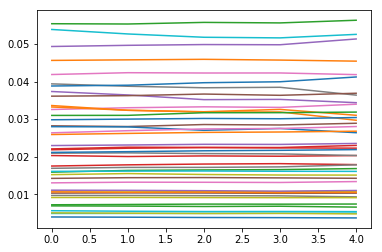

In [66]:
plt.plot([k for k in best_model.predict(np.reshape(data[-5:], (5, 1, data.shape[1])))])
plt.show()